# Tutorial 5 - Three-way branch migration energies

This example walks you through how to create multistranded complexes, how to find their energies, and how to find the energy of a test tube state with multiple complexes at a chosen concentration (i.e. box volume).  The example is toehold-initiated three-way branch migration, as per Zhang & Winfree, JACS, 2009.  Some things are done in a rather long-winded way, just to illustrate the use of Multistrand.  The intention is for you to try it line by line, and play around a bit.  E.g. use print() and help().

In [1]:
from multistrand.objects import *
from multistrand.options import Options
from multistrand.system import *

In [2]:
o = Options()
o.dangles = 1                # 0 is "None", 1 is "Some", 2 is "All".  You can use the string names only when passing as arguments to Options().
o.temperature = 25           # values between 0 and 100 are assumed to be Celsius; between 273.15 and 373.0 are assumed to be Kelvin.
o.join_concentration = 1e-9  # the volume is scaled such that a single strand is at 1 nM concentration.  
initialize_energy_model(o)   # only necessary if you want to use energy() without running a simulation first.

# More meaningful names for argument values to the energy() function call, below.
Loop_Energy = 0    # requesting no dG_assoc or dG_volume terms to be added.  So only loop energies remain.
Volume_Energy = 1  # requesting dG_volume but not dG_assoc terms to be added.  No clear interpretation for this.
Complex_Energy = 2 # requesting dG_assoc but not dG_volume terms to be added.  This is the NUPACK complex microstate energy, sans symmetry terms.
Tube_Energy = 3    # requesting both dG_assoc and dG_volume terms to be added.  Summed over complexes, this is the system state energy.

In [3]:
# Sequences are from Zhang & Winfree, JACS 2009.
toe = Domain(name='toehold',sequence='TCTCCATGTC')
bm = Domain(name='branch',sequence='CCCTCATTCAATACCCTACG')
extra = Domain(name='extra',sequence='CCACATACATCATATT')

In [4]:
substrate = toe.C + bm.C   # this.C computes the Watson-Crick complement; this + that combines Domains (or Strands) into a larger Strand.
substrate.name = "Substrate"
invasion = substrate.C
incumbent = extra + bm
incumbent.name = "Incumbent"

In [5]:
# Example showing that the reference state energy (all strands separate, unstructured) is defined to be 0.

c1= Complex(strands=[incumbent],structure='.'*len(incumbent.sequence))
c2= Complex(strands=[invasion],structure='.'*len(invasion.sequence))
c3= Complex(strands=[substrate],structure='.'*len(substrate.sequence))
ref = energy([c1,c2,c3],o,Tube_Energy)  # gives all zeros

In [6]:
# Example secondary structure in dot-paren notation, showing invading strand bound by the 10-nt toehold only.
# The two commands below are equivalent.  One gives the structure at the domain level, the other at the sequence level.
c = Complex( strands=[incumbent,invasion,substrate],structure=".(+.(+))")
c = Complex( strands=[incumbent,invasion,substrate],structure = "................((((((((((((((((((((+....................((((((((((+))))))))))))))))))))))))))))))")

In [7]:
# Another way to write the above dot-paren secondary structure:
st = "................" + 20 * "(" + "+" + 20*"." + "((((((((((+))))))))))" + 20 * ")"

In [8]:
print "<------- incumbent strand ---------> <------ invasion strand -----> <----- substrate strand ----->  (energy in kcal/mol)"
print incumbent.sequence + ' ' + invasion.sequence + ' ' + substrate.sequence

print "initial state"
c1 = Complex( strands=[invasion], structure='.'*len(invasion.sequence) )
st = "................((((((((((((((((((((+..........))))))))))))))))))))"
st = '.' * 16 + '(' * 20 + '+' + '.' * 10 + ')' * 20
c2 = Complex( strands=[incumbent,substrate], structure=st)
before = sum( energy([c1,c2],o,Tube_Energy) )
   # awkward wrap for indicating complexes on one line without permuting strand order
print st[:36] + ' ' +  '.'*30 + ' ' + st[37:] + '+' + " (%5.2f)" % before

<------- incumbent strand ---------> <------ invasion strand -----> <----- substrate strand ----->  (energy in kcal/mol)
CCACATACATCATATTCCCTCATTCAATACCCTACG CCCTCATTCAATACCCTACGTCTCCATGTC GACATGGAGACGTAGGGTATTGAATGAGGG
initial state
................(((((((((((((((((((( .............................. ..........))))))))))))))))))))+ (-18.04)


In [9]:
# Then we'll compute the energies for states as the toehold is binding, one base pair at a time.

print "toehold binding"

toeh = [0] * 10
for i in range(10)[::-1] :
    te = "................((((((((((((((((((((+...................." + (10-i)* "(" + i*"." + "+" + i*"." + (10-i)* ")" + "))))))))))))))))))))"
    c = Complex( strands=[incumbent,invasion,substrate],structure = te)
    toeh[9-i] = energy([c],o,Tube_Energy)[0]
    print te   + "  (%5.2f)" % toeh[9-i]

toehold binding
................((((((((((((((((((((+....................(.........+.........)))))))))))))))))))))  (-2.79)
................((((((((((((((((((((+....................((........+........))))))))))))))))))))))  (-5.24)
................((((((((((((((((((((+....................(((.......+.......)))))))))))))))))))))))  (-5.88)
................((((((((((((((((((((+....................((((......+......))))))))))))))))))))))))  (-8.02)
................((((((((((((((((((((+....................(((((.....+.....)))))))))))))))))))))))))  (-10.80)
................((((((((((((((((((((+....................((((((....+....))))))))))))))))))))))))))  (-11.22)
................((((((((((((((((((((+....................(((((((...+...)))))))))))))))))))))))))))  (-12.65)
................((((((((((((((((((((+....................((((((((..+..))))))))))))))))))))))))))))  (-15.26)
................((((((((((((((((((((+....................(((((((((.+.)))))))))))))))))))))))))))))  (-15.81)
.......

In [10]:
# Then we'll compute the energies for the three-stranded complex during branch migration steps and toehold binding steps

print "branch migration"
primary = [0] * 20   # structures with full base-pairing
intermed = [0] * 19  # structures with one base-pair open
for i in range(20):
    st = "................" + (20-i) * "(" + i*"." + "+" + (20-i)*"." + i*"(" + "((((((((((+))))))))))" + 20 * ")"
    c = Complex( strands=[incumbent,invasion,substrate],structure = st)
    primary[i] = energy([c],o,Tube_Energy)[0]
    print st  + "  (%5.2f)" % primary[i]
    
    if i<19:
        st_int = "................" + (19-i) * "(" + (i+1)*"." + "+" + (20-i)*"." + i*"(" + "((((((((((+))))))))))" + i * ")" + "." + (19-i) * ")"
        c = Complex( strands=[incumbent,invasion,substrate],structure = st_int)
        intermed[i] = energy([c],o,Tube_Energy)[0]
        print st_int  + "  (%5.2f)" % intermed[i]

branch migration
................((((((((((((((((((((+....................((((((((((+))))))))))))))))))))))))))))))  (-16.86)
................(((((((((((((((((((.+....................((((((((((+)))))))))).)))))))))))))))))))  (-14.98)
................(((((((((((((((((((.+...................(((((((((((+))))))))))))))))))))))))))))))  (-17.12)
................((((((((((((((((((..+...................(((((((((((+))))))))))).))))))))))))))))))  (-14.83)
................((((((((((((((((((..+..................((((((((((((+))))))))))))))))))))))))))))))  (-17.87)
................(((((((((((((((((...+..................((((((((((((+)))))))))))).)))))))))))))))))  (-18.93)
................(((((((((((((((((...+.................(((((((((((((+))))))))))))))))))))))))))))))  (-19.34)
................((((((((((((((((....+.................(((((((((((((+))))))))))))).))))))))))))))))  (-18.85)
................((((((((((((((((....+................((((((((((((((+))))))))))))))))))))))))))))))  (-18.21)
..

In [11]:
# Note that toeh[9] == primary[0]
energies = toeh[:9]+[primary[i/2] if i%2==0 else intermed[i/2] for i in range(len(primary)+len(intermed))]
steps    = range(-9,0)+[v/2.0 for v in range(0,39)]

# Finally we'll compute the energies for the tube system states consisting of two complexes after strand displacement.

print 'dissociated states'

     # Immediately after dissociation, the just-broken base pair is open
c1 = Complex( strands=[incumbent], structure='.'*len(incumbent.sequence) )
st = '.' + '(' * 29 + '+' + ')' * 29 + '.'
c2 = Complex( strands=[invasion,substrate], structure=st)
after_open = sum( energy([c1,c2],o,Tube_Energy) )
print '.'*36 + ' ' + st + "  (%5.2f)" % after_open

dissociated states
.................................... .(((((((((((((((((((((((((((((+))))))))))))))))))))))))))))).  (-31.62)


In [12]:
     # Now the final base pair closes.
c1 = Complex( strands=[incumbent], structure='.'*len(incumbent.sequence) )
st = '(' * 30 + '+' + ')' * 30
c2 = Complex( strands=[invasion,substrate], structure=st)
after_closed = sum( energy([c1,c2],o,Tube_Energy) )
print '.'*36 + ' ' + st + "  (%5.2f)" % after_closed

.................................... ((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))  (-32.46)


In [13]:
# Store the before and after states in "positions" -15 and +25,+26 so as to visually separate them from the intramolecular pathway.
energies = [before] + energies + [after_open, after_closed]
steps = [-15] + steps + [25,26]

Bring on the plots!

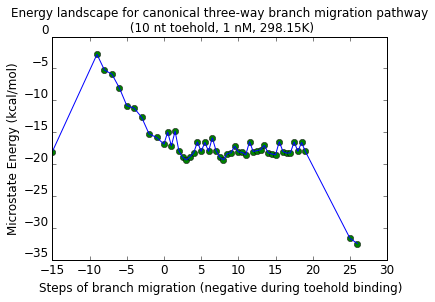

In [14]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
plt.figure(1)
plt.plot(steps,energies,'go',steps,energies,'-')
plt.title("Energy landscape for canonical three-way branch migration pathway\n (10 nt toehold, %d nM, %6.2fK)" % (o.join_concentration * 1e9, o.temperature) )
plt.xlabel("Steps of branch migration (negative during toehold binding)",fontsize='larger')
plt.ylabel("Microstate Energy (kcal/mol)",fontsize='larger')
plt.yticks(fontsize='larger',va='bottom')
plt.xticks(fontsize='larger')
plt.show()